<h3>Predicting UK rental prices</h3>

In [66]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import lib, data, model
import graphs as gr
 
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<h3>Part 1: Getting the Data</h3>

In [67]:
# breaking into diff files due to API call limits of 100 per hour ---->
# CV 5262 - FILE 1
# LA 691  | PE 1857 | SK 593 - FILE 2
# CF 3886 | RG 3772 | BS 2074 - FILE 3
# SO 3807 | DN 1310 | EX 1211 | PO 2582 - FILE 4
# LE 2890 |  LS 7000 - FILE 5
# NG 3149 |  YO 753 | BA 1056 - FILE 6
# M1 TO 50 - FILE 7
# Sheffield 2528 | Birmingham 4794 - FILE 8
# Liverpool 3300 ish - File 9

# postcodes = ['liverpool']
# df9 = data.getRegionalData(postcodes,'20200117',9)


In [68]:
concatenated_df = data.joinData()

In [45]:
# concatenated_df.head(3).T

In [69]:
# cleaning the dataset
df = data.cleanData(concatenated_df)
df.shape

(74068, 21)

<h3>Part 2:EDA</h3>

<h4>Question 1: Where should I buy?</h4>

In [4]:
df.county.value_counts()

London                      24566
West Midlands                7300
West Yorkshire               4845
Greater Manchester           3782
Hampshire                    2895
Merseyside                   2796
Southampton                  2792
South Yorkshire              2786
Leicestershire               2548
Berkshire                    2462
Cardiff                      2352
Nottingham                   2122
Bristol                      1545
Warwickshire                 1436
Devon                         925
Peterborough                  702
North Yorkshire               656
Lincolnshire                  592
Rhondda Cynon Taff            579
Lancashire                    532
Bath & N E Somerset           521
Cambridgeshire                509
Nottinghamshire               488
West Sussex                   329
West Berkshire                304
Somerset                      279
North East Lincolnshire       184
North Lincolnshire            161
Norfolk                       159
Bridgend      

<h4>Question 2: Where type of houses should I buy?</h4>

In [110]:
region = df
region = df[(df['student'] == 1) | (df['shared_occu'] == 1)]

region = region[(region['num_bathrooms'] != 0)]
region = region[(region['num_bedrooms'] <= 10)]


includes = ['Bath & N E Somerset']

def matcher(x):
    for i in includes:
        if x == i:
            return 1
    else:
        return 0

region['include'] = region['county'].apply(matcher)

region = region[region['include']==1]
region.shape

(163, 22)

In [111]:
grouped = data.getPerBedroomOvreview(region)

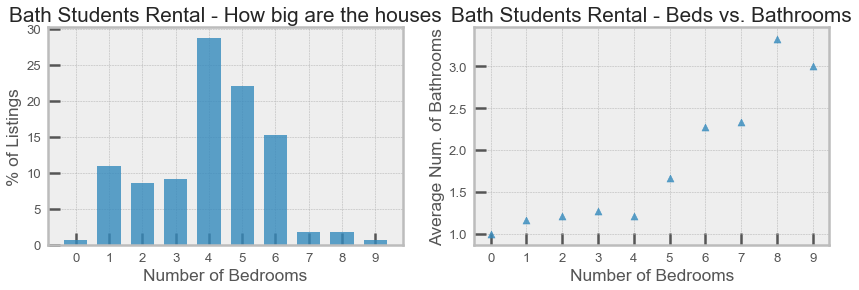

In [115]:
# sns.set_style("darkgrid")
# sns.set_palette("colorblind")
plt.style.use('bmh')
title = 'Bath Students'
gr.areaOverview(grouped,title)

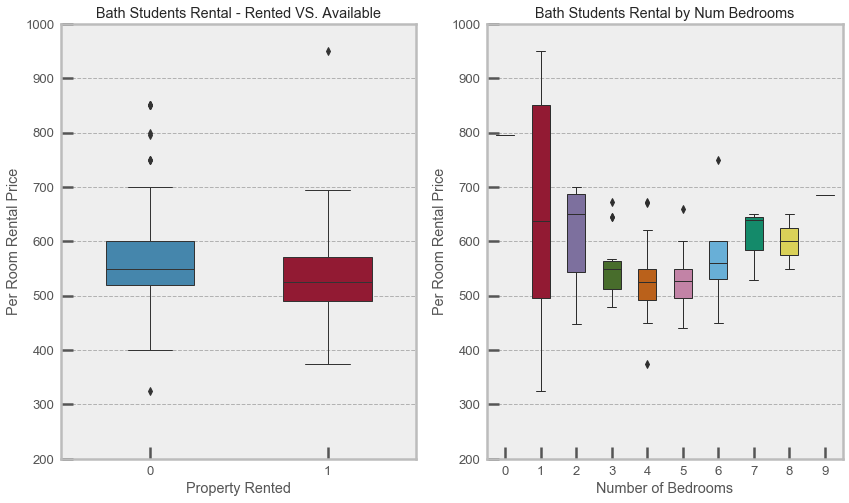

In [116]:
gr.rentPriceGraphs(region,title,'room_pm',200,1_000)

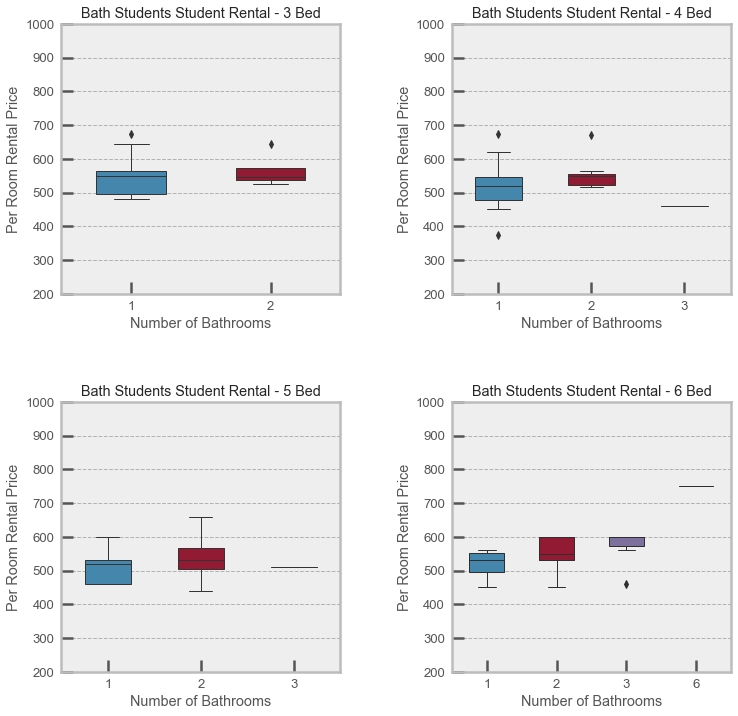

In [117]:
gr.rentPriceBedBath(region,title,'room_pm',200,1000)

In [118]:
data.getBathroomsByProperSize(region)

,num_bedrooms,num_bathrooms,count,proportion%,rent_pm
0,0,1,1,100.0,795.0
1,1,1,15,83.3,750.0
2,1,2,3,16.7,495.0
3,2,1,11,78.6,648.0
4,2,2,3,21.4,692.0
5,3,1,11,73.3,550.0
6,3,2,4,26.7,545.0
7,4,1,38,80.9,520.0
8,4,2,8,17.0,550.0
9,4,3,1,2.1,460.0


<h5>Part 3: Modelling</h5>

In [278]:
# df[df['county']=='Berkshire'].post_town.value_counts()

In [279]:
region = df
region = df[(df['student'] == 1) | (df['shared_occu'] == 1)]

region = region[(region['num_bathrooms'] != 0)]
region = region[(region['num_bedrooms'] <= 10)]

# R2 80% for all, 80% for students
south_west = ['Bristol','Bath & N E Somerset','Wiltshire','North Somerset','Somerset',
           'Hampshire','Southampton','Devon',
           'Berkshire','West Berkshire',
             'Cardiff']

# R2 76% for all, 76% for students
north_west = ['Greater Manchester','Merseyside','Lancashire']

# R2 72% for all, 72% for students - POST_TOWN
midlands = ['Coventry','Leamington Spa','Peterborough']

# R2 63% for all, 42% for students
north_east = ['West Yorkshire','South Yorkshire','North Yorkshire']

# includes = ['Bristol']

def matcher(x):
    for i in includes:
        if x == i:
            return 1
    else:
        return 0

In [280]:
# run the model with Bristol as an example

includes = ['Bath & N E Somerset']

region['include'] = region['county'].apply(matcher)
# region['include'] = region['post_twon'].apply(matcher)

region = region[region['include']==1]

print(region.shape)

(163, 22)


Training r^2 %: 95.198
Testing r^2 %: 92.407
Training MSE (mil): 0.049041207675340266
Testing MSE (mil): 0.0705035126637266
----------
Training r^2 %: 98.232
Testing r^2 %: -1.1720535046191716e+23
Training MSE (mil): 0.01805135110420093
Testing MSE (mil): 1.0883264288136009e+21
----------
Training r^2 %: 98.157
Testing r^2 %: 93.478
Training MSE (mil): 0.018817289409070466
Testing MSE (mil): 0.060560551057693555


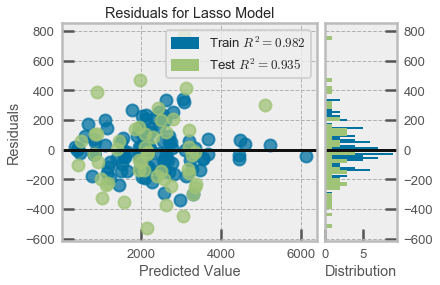

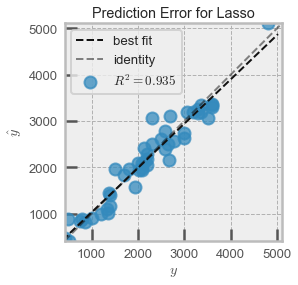

In [281]:

X = region.drop(columns=['rent_price','listing_id','description','details_url',
                         'first_published_date','outcode','room_pm','student','county','post_town','include'])
y = region['rent_price']

run = model.ModelTry(X,y)


## Perform a first naive linear regression model using only Continious Data Variables
lin_con, coef1, X_train, y_train, scaler, poly, ohe = run.run_model(1, False, False)
print("----------")

## add in the categorical variables ---- OVERFITTING with outcode
# lin_reg, coef2, X_train, y_train = run.run_model(2, False, False)
# print("----------")

## add in the polynomial interactions, CHECK effects of overfitting here
lin_poly, coef3, X_train, y_train, scaler, poly, ohe = run.run_model(2, False, True)
print("----------")

## use Lasso model to compact effects of overfitting
las, coef4, X_train, y_train, scaler, poly, ohe = run.run_model(3, True, True)

In [282]:
coef4.sort_values('coef_abs', ascending=False).head(10)
# region.head()
# more negative longitude means more west

,coef_value,coef_abs
num_bathrooms,895.305826,895.305826
property_type_Detached house,186.638027,186.638027
furnished_state_furnished_or_unfurnished,133.305672,133.305672
property_type_Missing,104.767160,104.767160
property_type_Semi-detached house,-98.916369,98.916369
bills_included furnished_state,-72.032602,72.032602
longitude num_bathrooms,64.877472,64.877472
longitude num_bedrooms,-60.039858,60.039858
latitude longitude,58.475368,58.475368
floor_plan num_bedrooms,-57.106180,57.106180


<h5>Part 4: Predicting rental price with given inputs</h5>

In [283]:
def predict_transform(A):
    # remove "object"-type features and y from `X`
    con_features = [ col for col in A.columns if A[col].dtype in ['int64','float64']]
    A_con = A.loc[:,con_features]


    # Scale the train and test data
    A_sca = scaler.transform(A_con)


    # add in the polynomial interations for the cont. variables
    A_poly = poly.transform(A_sca)
    A_cols = poly.get_feature_names(A.columns)


    # Create X_cat which contains only the categorical variables
    cat_features = [ col for col in A.columns if A[col].dtype == np.object]
    A_cat = A.loc[:,cat_features]


    # OneHotEncode Categorical variables
    A_ohe = ohe.transform(A_cat)

    columns = ohe.get_feature_names(input_features=A_cat.columns)
    cat_df = pd.DataFrame(A_ohe.todense(), columns=columns)

    A_all = pd.concat([pd.DataFrame(A_poly, columns=A_cols), cat_df], axis = 1)

    return A_all


In [299]:

A = X.head(1)

# reading house 51.447366, -0.948203
# bath house 51.358789, -2.371651
A.loc[:,'bills_included'] = 0
A.loc[:,'floor_plan'] = 1
A['furnished_state'] = 'furnished'
A['latitude'] = 51.358789
A['longitude'] = -2.371651
A['num_bathrooms'] = 2
A['num_bedrooms'] = 3
A.num_recepts = 1
A.property_type = 'Flats'
A.shared_occu = 1
A.rented = 0

# Try using df.loc[row_index,col_indexer] = value
# A.columns = ['bills_included','floor_plan','furnished_state','latitude','longitude',
#              'num_bathrooms','num_bedrooms','num_recepts','property_type','shared_occu','rented']

In [300]:
X.head(1)

,bills_included,floor_plan,furnished_state,latitude,longitude,num_bathrooms,num_bedrooms,num_recepts,property_type,shared_occu,rented
91701,0.0,1,furnished,51.358789,-2.371651,2,3,1,Flats,1,0


In [301]:
# prediction of monthly rental price ->
A_tr = predict_transform(X.head(1))
las.predict(A_tr)

array([1519.19388056])

In [65]:
# region.head()
# more negative longitude means more west